# Toy Example

Figure 1 in the [paper](https://arxiv.org/abs/2007.09670).

In [1]:
import os
import sys

os.chdir('..')
sys.path.append('..')

In [2]:
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from pprint import pprint

from neural_pi.utils import Timer
from neural_pi.estimator.base import Randomness
from neural_pi.data import SyntheticDataset
from neural_pi.estimator import PiEnsemble, Adam, ExponentialDecay, qd_plus_loss, snm_aggreg

## Randomness

In [3]:
SEED = 398723

randomness = Randomness(SEED)
r_seed = randomness.random_seed()
run_dir = 'temp/run_%s' % r_seed

## Dataset

In [4]:
def plot_dataset(x, mu, q_l, q_u, x_train, y_train, x_val, y_val, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.ylim(-4.3, 4.3)
    ax.plot(x, mu, linewidth=0.7, color='black', alpha=0.5)
    ax.fill_between(x, q_l, q_u, color='0.9', alpha=1.0)
    ax.scatter(x_train, y_train, color='blue', s=0.1, alpha=0.7)
    ax.scatter(x_val, y_val, color='red', s=0.1, alpha=0.7)
    plt.show()

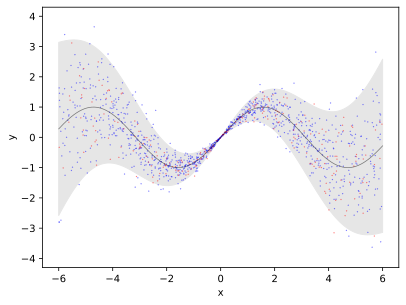

In [5]:
dataset = SyntheticDataset()
dataset.load(r_seed)

plot_dataset(**dataset.data)

In [6]:
x = dataset.data['x']
x_train = dataset.data['x_train']
y_train = dataset.data['y_train']
x_val = dataset.data['x_val']
y_val = dataset.data['y_val']

In [7]:
x_train.shape

(1000,)

In [8]:
x_val.shape

(250,)

## Configuration (QD+)

In [9]:
method = PiEnsemble
hyper_params=dict(
    ensemble_size=5,
    aggreg_func=snm_aggreg,
    hidden_size=[50],
    epochs=5000,
    batch_size=50,
    optimizer=Adam,
    learning_rate=0.001,
    scheduler=ExponentialDecay,
    decay_rate=1.,
    decay_steps=50.,
    early_stopping=True,
    patience=500,
    delta=1e-6,
    tolerance=0.01,
    loss_func=qd_plus_loss,
    alpha=0.05,  # gamma = 0.95
    soften=160.,
    lambda_1=0.99,
    lambda_2=0.3,
    ksi=10.,
    print_frequency=10,
    device='cpu'
)

## Training

In [10]:
x_train_ = np.reshape(x_train, (x_train.shape[0], 1)).astype(np.float32)
y_train_ = np.reshape(y_train, (y_train.shape[0], 1)).astype(np.float32)
x_val_ = np.reshape(x_val, (x_val.shape[0], 1)).astype(np.float32)
y_val_ = np.reshape(y_val, (y_val.shape[0], 1)).astype(np.float32)

x_scaler = StandardScaler()
x_scaler.fit(x_train_)
x_train_ = x_scaler.transform(x_train_)
x_val_ = x_scaler.transform(x_val_)

y_scaler = StandardScaler()
y_scaler.fit(y_train_)
y_train_ = y_scaler.transform(y_train_)
y_val_ = y_scaler.transform(y_val_)

print('═ Training [seed=%s]' % r_seed)
timer = Timer().start()

estimator = method(**hyper_params, seed=r_seed, output_dir=run_dir)
estimator.fit(x_train_, y_train_, x_val_, y_val_)

timer.stop()
print('\n═ Finished [duration=%.1f s]' % timer.duration())

═ Training [seed=16161856]

─ Model 1 of 5 [seed=152980226]
ep:    0  train  picp 0.020000  mpiw -0.018260  cross 0.485000  mse 1.050003  pimse 1.044881  within 0.515000  loss 1.979807  epochs 5000.000000  lr 0.001000
ep:    0  valid  picp 0.028000  mpiw -0.039525  cross 0.532000  mse 1.127935  pimse 1.111319  within 0.468000  loss 2.129026  epochs 5000.000000  lr 0.001000
ep:   10  train  picp 0.490000  mpiw 1.440702  cross 0.000000  mse 0.954030  pimse 1.080653  within 1.000000  loss 0.444032  epochs 5000.000000  lr 0.001000
ep:   10  valid  picp 0.440000  mpiw 1.382772  cross 0.000000  mse 1.006391  pimse 1.124767  within 1.000000  loss 0.493072  epochs 5000.000000  lr 0.001000
ep:   20  train  picp 0.726000  mpiw 2.343699  cross 0.000000  mse 0.922325  pimse 1.064678  within 1.000000  loss 0.329654  epochs 5000.000000  lr 0.001000
ep:   20  valid  picp 0.696000  mpiw 2.264430  cross 0.000000  mse 0.964355  pimse 1.122538  within 1.000000  loss 0.351716  epochs 5000.000000  lr 0.001

ep:  260  train  picp 0.917000  mpiw 2.753258  cross 0.000000  mse 0.555277  pimse 0.841939  within 1.000000  loss 0.186469  epochs 5000.000000  lr 0.001000
ep:  260  valid  picp 0.904000  mpiw 2.771888  cross 0.000000  mse 0.523578  pimse 0.874198  within 1.000000  loss 0.177892  epochs 5000.000000  lr 0.001000
ep:  270  train  picp 0.914000  mpiw 2.723588  cross 0.000000  mse 0.553548  pimse 0.833363  within 1.000000  loss 0.185812  epochs 5000.000000  lr 0.001000
ep:  270  valid  picp 0.900000  mpiw 2.740211  cross 0.000000  mse 0.519187  pimse 0.872242  within 1.000000  loss 0.176543  epochs 5000.000000  lr 0.001000
ep:  280  train  picp 0.916000  mpiw 2.715898  cross 0.000000  mse 0.552300  pimse 0.813274  within 1.000000  loss 0.185360  epochs 5000.000000  lr 0.001000
ep:  280  valid  picp 0.900000  mpiw 2.730028  cross 0.000000  mse 0.520151  pimse 0.840530  within 1.000000  loss 0.176862  epochs 5000.000000  lr 0.001000
ep:  290  train  picp 0.915000  mpiw 2.720926  cross 0.000

ep:  530  train  picp 0.907000  mpiw 2.328948  cross 0.000000  mse 0.526136  pimse 0.684757  within 1.000000  loss 0.174971  epochs 5000.000000  lr 0.001000
ep:  530  valid  picp 0.884000  mpiw 2.347183  cross 0.000000  mse 0.498843  pimse 0.706568  within 1.000000  loss 0.168559  epochs 5000.000000  lr 0.001000
ep:  540  train  picp 0.926000  mpiw 2.440065  cross 0.000000  mse 0.525126  pimse 0.660682  within 1.000000  loss 0.174730  epochs 5000.000000  lr 0.001000
ep:  540  valid  picp 0.908000  mpiw 2.444855  cross 0.000000  mse 0.499215  pimse 0.673062  within 1.000000  loss 0.167875  epochs 5000.000000  lr 0.001000
ep:  550  train  picp 0.925000  mpiw 2.484516  cross 0.000000  mse 0.524345  pimse 0.674500  within 1.000000  loss 0.174815  epochs 5000.000000  lr 0.001000
ep:  550  valid  picp 0.912000  mpiw 2.490070  cross 0.000000  mse 0.497650  pimse 0.699107  within 1.000000  loss 0.167408  epochs 5000.000000  lr 0.001000
ep:  560  train  picp 0.924000  mpiw 2.419561  cross 0.000

ep:  800  train  picp 0.917000  mpiw 2.116136  cross 0.000000  mse 0.502547  pimse 0.595186  within 1.000000  loss 0.165939  epochs 5000.000000  lr 0.001000
ep:  800  valid  picp 0.916000  mpiw 2.149334  cross 0.000000  mse 0.474639  pimse 0.585636  within 1.000000  loss 0.157904  epochs 5000.000000  lr 0.001000
ep:  810  train  picp 0.913000  mpiw 2.110367  cross 0.000000  mse 0.502029  pimse 0.595274  within 1.000000  loss 0.165951  epochs 5000.000000  lr 0.001000
ep:  810  valid  picp 0.904000  mpiw 2.145306  cross 0.000000  mse 0.470554  pimse 0.578853  within 1.000000  loss 0.157171  epochs 5000.000000  lr 0.001000
ep:  820  train  picp 0.914000  mpiw 2.116456  cross 0.000000  mse 0.501151  pimse 0.599779  within 1.000000  loss 0.165601  epochs 5000.000000  lr 0.001000
ep:  820  valid  picp 0.928000  mpiw 2.138910  cross 0.000000  mse 0.470705  pimse 0.594125  within 1.000000  loss 0.156166  epochs 5000.000000  lr 0.001000
ep:  830  train  picp 0.930000  mpiw 2.214510  cross 0.000

ep: 1070  train  picp 0.910000  mpiw 1.917540  cross 0.000000  mse 0.490842  pimse 0.598309  within 1.000000  loss 0.161163  epochs 5000.000000  lr 0.001000
ep: 1070  valid  picp 0.916000  mpiw 1.947712  cross 0.000000  mse 0.458147  pimse 0.536268  within 1.000000  loss 0.151404  epochs 5000.000000  lr 0.001000
ep: 1080  train  picp 0.912000  mpiw 1.937771  cross 0.000000  mse 0.490389  pimse 0.597212  within 1.000000  loss 0.161127  epochs 5000.000000  lr 0.001000
ep: 1080  valid  picp 0.920000  mpiw 1.970754  cross 0.000000  mse 0.457168  pimse 0.543264  within 1.000000  loss 0.151124  epochs 5000.000000  lr 0.001000
ep: 1090  train  picp 0.923000  mpiw 1.982835  cross 0.000000  mse 0.490354  pimse 0.623310  within 1.000000  loss 0.161034  epochs 5000.000000  lr 0.001000
ep: 1090  valid  picp 0.932000  mpiw 2.029181  cross 0.000000  mse 0.457467  pimse 0.543833  within 1.000000  loss 0.151349  epochs 5000.000000  lr 0.001000
ep: 1100  train  picp 0.918000  mpiw 1.947947  cross 0.000

ep: 1340  train  picp 0.914000  mpiw 1.879080  cross 0.000000  mse 0.486796  pimse 0.600822  within 1.000000  loss 0.159597  epochs 5000.000000  lr 0.001000
ep: 1340  valid  picp 0.920000  mpiw 1.925019  cross 0.000000  mse 0.449762  pimse 0.525115  within 1.000000  loss 0.148678  epochs 5000.000000  lr 0.001000
ep: 1350  train  picp 0.920000  mpiw 1.939480  cross 0.000000  mse 0.486047  pimse 0.597930  within 1.000000  loss 0.159482  epochs 5000.000000  lr 0.001000
ep: 1350  valid  picp 0.932000  mpiw 1.978244  cross 0.000000  mse 0.454160  pimse 0.532275  within 1.000000  loss 0.149901  epochs 5000.000000  lr 0.001000
ep: 1360  train  picp 0.925000  mpiw 2.031995  cross 0.000000  mse 0.485888  pimse 0.590397  within 1.000000  loss 0.159859  epochs 5000.000000  lr 0.001000
ep: 1360  valid  picp 0.932000  mpiw 2.064012  cross 0.000000  mse 0.453268  pimse 0.518766  within 1.000000  loss 0.150124  epochs 5000.000000  lr 0.001000
ep: 1370  train  picp 0.920000  mpiw 1.997242  cross 0.000

ep: 1610  train  picp 0.915000  mpiw 1.880304  cross 0.000000  mse 0.485290  pimse 0.599606  within 1.000000  loss 0.159122  epochs 5000.000000  lr 0.001000
ep: 1610  valid  picp 0.924000  mpiw 1.928834  cross 0.000000  mse 0.456218  pimse 0.527684  within 1.000000  loss 0.150492  epochs 5000.000000  lr 0.001000
ep: 1620  train  picp 0.918000  mpiw 1.896639  cross 0.000000  mse 0.485627  pimse 0.586856  within 1.000000  loss 0.159246  epochs 5000.000000  lr 0.001000
ep: 1620  valid  picp 0.928000  mpiw 1.949142  cross 0.000000  mse 0.446741  pimse 0.517506  within 1.000000  loss 0.147602  epochs 5000.000000  lr 0.001000
ep: 1630  train  picp 0.928000  mpiw 1.988381  cross 0.000000  mse 0.484168  pimse 0.599097  within 1.000000  loss 0.159006  epochs 5000.000000  lr 0.001000
ep: 1630  valid  picp 0.944000  mpiw 2.037075  cross 0.000000  mse 0.453533  pimse 0.529239  within 1.000000  loss 0.150044  epochs 5000.000000  lr 0.001000
ep: 1640  train  picp 0.923000  mpiw 1.941404  cross 0.000

ep: 1880  train  picp 0.918000  mpiw 1.903845  cross 0.000000  mse 0.483440  pimse 0.575145  within 1.000000  loss 0.158535  epochs 5000.000000  lr 0.001000
ep: 1880  valid  picp 0.924000  mpiw 1.933726  cross 0.000000  mse 0.450289  pimse 0.523755  within 1.000000  loss 0.148648  epochs 5000.000000  lr 0.001000
ep: 1890  train  picp 0.911000  mpiw 1.863806  cross 0.000000  mse 0.483114  pimse 0.572922  within 1.000000  loss 0.158520  epochs 5000.000000  lr 0.001000
ep: 1890  valid  picp 0.920000  mpiw 1.905298  cross 0.000000  mse 0.451767  pimse 0.523413  within 1.000000  loss 0.148991  epochs 5000.000000  lr 0.001000
ep: 1900  train  picp 0.913000  mpiw 1.843741  cross 0.000000  mse 0.483016  pimse 0.582143  within 1.000000  loss 0.158241  epochs 5000.000000  lr 0.001000
ep: 1900  valid  picp 0.912000  mpiw 1.873113  cross 0.000000  mse 0.453292  pimse 0.543506  within 1.000000  loss 0.149510  epochs 5000.000000  lr 0.001000
ep: 1910  train  picp 0.927000  mpiw 1.953981  cross 0.000

ep: 2150  train  picp 0.933000  mpiw 2.012147  cross 0.000000  mse 0.482305  pimse 0.614007  within 1.000000  loss 0.158497  epochs 5000.000000  lr 0.001000
ep: 2150  valid  picp 0.932000  mpiw 2.049260  cross 0.000000  mse 0.451048  pimse 0.544344  within 1.000000  loss 0.149500  epochs 5000.000000  lr 0.001000
ep: 2160  train  picp 0.922000  mpiw 1.908633  cross 0.000000  mse 0.482708  pimse 0.573453  within 1.000000  loss 0.158232  epochs 5000.000000  lr 0.001000
ep: 2160  valid  picp 0.924000  mpiw 1.962772  cross 0.000000  mse 0.449380  pimse 0.510112  within 1.000000  loss 0.148538  epochs 5000.000000  lr 0.001000
ep: 2170  train  picp 0.921000  mpiw 1.900309  cross 0.000000  mse 0.482160  pimse 0.573286  within 1.000000  loss 0.158003  epochs 5000.000000  lr 0.001000
ep: 2170  valid  picp 0.932000  mpiw 1.934005  cross 0.000000  mse 0.452083  pimse 0.515933  within 1.000000  loss 0.148978  epochs 5000.000000  lr 0.001000
ep: 2180  train  picp 0.912000  mpiw 1.850328  cross 0.000

ep:  180  train  picp 0.902000  mpiw 3.139104  cross 0.000000  mse 0.571773  pimse 1.092126  within 1.000000  loss 0.194998  epochs 5000.000000  lr 0.001000
ep:  180  valid  picp 0.880000  mpiw 3.114675  cross 0.000000  mse 0.539910  pimse 1.226238  within 1.000000  loss 0.187107  epochs 5000.000000  lr 0.001000
ep:  190  train  picp 0.902000  mpiw 3.093460  cross 0.000000  mse 0.568831  pimse 1.071383  within 1.000000  loss 0.193824  epochs 5000.000000  lr 0.001000
ep:  190  valid  picp 0.876000  mpiw 3.068911  cross 0.000000  mse 0.529538  pimse 1.199736  within 1.000000  loss 0.183942  epochs 5000.000000  lr 0.001000
ep:  200  train  picp 0.895000  mpiw 2.981005  cross 0.000000  mse 0.567965  pimse 1.050875  within 1.000000  loss 0.193102  epochs 5000.000000  lr 0.001000
ep:  200  valid  picp 0.872000  mpiw 2.966096  cross 0.000000  mse 0.525904  pimse 1.172749  within 1.000000  loss 0.182548  epochs 5000.000000  lr 0.001000
ep:  210  train  picp 0.919000  mpiw 3.064800  cross 0.000

ep:  450  train  picp 0.924000  mpiw 2.548587  cross 0.000000  mse 0.530653  pimse 0.700641  within 1.000000  loss 0.177250  epochs 5000.000000  lr 0.001000
ep:  450  valid  picp 0.908000  mpiw 2.551551  cross 0.000000  mse 0.502242  pimse 0.719712  within 1.000000  loss 0.169549  epochs 5000.000000  lr 0.001000
ep:  460  train  picp 0.930000  mpiw 2.580452  cross 0.000000  mse 0.529839  pimse 0.694301  within 1.000000  loss 0.177021  epochs 5000.000000  lr 0.001000
ep:  460  valid  picp 0.916000  mpiw 2.587078  cross 0.000000  mse 0.502792  pimse 0.710495  within 1.000000  loss 0.169560  epochs 5000.000000  lr 0.001000
ep:  470  train  picp 0.924000  mpiw 2.487165  cross 0.000000  mse 0.528196  pimse 0.686765  within 1.000000  loss 0.176070  epochs 5000.000000  lr 0.001000
ep:  470  valid  picp 0.908000  mpiw 2.496955  cross 0.000000  mse 0.497487  pimse 0.703479  within 1.000000  loss 0.167733  epochs 5000.000000  lr 0.001000
ep:  480  train  picp 0.919000  mpiw 2.433052  cross 0.000

ep:  720  train  picp 0.927000  mpiw 2.268235  cross 0.000000  mse 0.509200  pimse 0.599816  within 1.000000  loss 0.168644  epochs 5000.000000  lr 0.001000
ep:  720  valid  picp 0.920000  mpiw 2.298513  cross 0.000000  mse 0.488269  pimse 0.582641  within 1.000000  loss 0.162834  epochs 5000.000000  lr 0.001000
ep:  730  train  picp 0.927000  mpiw 2.285431  cross 0.000000  mse 0.508764  pimse 0.597758  within 1.000000  loss 0.168611  epochs 5000.000000  lr 0.001000
ep:  730  valid  picp 0.924000  mpiw 2.310943  cross 0.000000  mse 0.486734  pimse 0.578449  within 1.000000  loss 0.162391  epochs 5000.000000  lr 0.001000
ep:  740  train  picp 0.920000  mpiw 2.242379  cross 0.000000  mse 0.508644  pimse 0.613804  within 1.000000  loss 0.168471  epochs 5000.000000  lr 0.001000
ep:  740  valid  picp 0.920000  mpiw 2.271611  cross 0.000000  mse 0.490447  pimse 0.613290  within 1.000000  loss 0.163266  epochs 5000.000000  lr 0.001000
ep:  750  train  picp 0.919000  mpiw 2.208627  cross 0.000

ep:  990  train  picp 0.919000  mpiw 2.031747  cross 0.000000  mse 0.502487  pimse 0.610421  within 1.000000  loss 0.165077  epochs 5000.000000  lr 0.001000
ep:  990  valid  picp 0.920000  mpiw 2.063496  cross 0.000000  mse 0.479051  pimse 0.596324  within 1.000000  loss 0.158369  epochs 5000.000000  lr 0.001000
ep: 1000  train  picp 0.905000  mpiw 1.863564  cross 0.000000  mse 0.502440  pimse 0.579469  within 1.000000  loss 0.164685  epochs 5000.000000  lr 0.001000
ep: 1000  valid  picp 0.900000  mpiw 1.905979  cross 0.000000  mse 0.477881  pimse 0.543825  within 1.000000  loss 0.157800  epochs 5000.000000  lr 0.001000
ep: 1010  train  picp 0.921000  mpiw 1.996502  cross 0.000000  mse 0.505070  pimse 0.600809  within 1.000000  loss 0.165587  epochs 5000.000000  lr 0.001000
ep: 1010  valid  picp 0.920000  mpiw 2.024551  cross 0.000000  mse 0.486419  pimse 0.568428  within 1.000000  loss 0.160272  epochs 5000.000000  lr 0.001000
ep: 1020  train  picp 0.918000  mpiw 1.971118  cross 0.000

ep: 1260  train  picp 0.920000  mpiw 1.938832  cross 0.000000  mse 0.498286  pimse 0.558055  within 1.000000  loss 0.163191  epochs 5000.000000  lr 0.001000
ep: 1260  valid  picp 0.928000  mpiw 1.975604  cross 0.000000  mse 0.479174  pimse 0.500999  within 1.000000  loss 0.157452  epochs 5000.000000  lr 0.001000
ep: 1270  train  picp 0.914000  mpiw 1.923720  cross 0.000000  mse 0.498092  pimse 0.558747  within 1.000000  loss 0.163293  epochs 5000.000000  lr 0.001000
ep: 1270  valid  picp 0.936000  mpiw 1.964805  cross 0.000000  mse 0.477212  pimse 0.500772  within 1.000000  loss 0.156673  epochs 5000.000000  lr 0.001000
ep: 1280  train  picp 0.919000  mpiw 1.885733  cross 0.000000  mse 0.497895  pimse 0.563452  within 1.000000  loss 0.162803  epochs 5000.000000  lr 0.001000
ep: 1280  valid  picp 0.920000  mpiw 1.926060  cross 0.000000  mse 0.477860  pimse 0.508332  within 1.000000  loss 0.157009  epochs 5000.000000  lr 0.001000
ep: 1290  train  picp 0.917000  mpiw 1.883683  cross 0.000

ep: 1530  train  picp 0.930000  mpiw 1.952722  cross 0.000000  mse 0.494948  pimse 0.577080  within 1.000000  loss 0.162007  epochs 5000.000000  lr 0.001000
ep: 1530  valid  picp 0.940000  mpiw 1.999884  cross 0.000000  mse 0.472870  pimse 0.515359  within 1.000000  loss 0.155626  epochs 5000.000000  lr 0.001000
ep: 1540  train  picp 0.922000  mpiw 1.899160  cross 0.000000  mse 0.495065  pimse 0.560908  within 1.000000  loss 0.161874  epochs 5000.000000  lr 0.001000
ep: 1540  valid  picp 0.936000  mpiw 1.947045  cross 0.000000  mse 0.472604  pimse 0.499599  within 1.000000  loss 0.155220  epochs 5000.000000  lr 0.001000
ep: 1550  train  picp 0.925000  mpiw 1.944127  cross 0.000000  mse 0.494884  pimse 0.599141  within 1.000000  loss 0.162066  epochs 5000.000000  lr 0.001000
ep: 1550  valid  picp 0.928000  mpiw 1.991989  cross 0.000000  mse 0.473700  pimse 0.536827  within 1.000000  loss 0.156036  epochs 5000.000000  lr 0.001000
ep: 1560  train  picp 0.927000  mpiw 1.925788  cross 0.000

ep: 1800  train  picp 0.924000  mpiw 1.930355  cross 0.000000  mse 0.493328  pimse 0.564389  within 1.000000  loss 0.161460  epochs 5000.000000  lr 0.001000
ep: 1800  valid  picp 0.932000  mpiw 1.969188  cross 0.000000  mse 0.467934  pimse 0.515805  within 1.000000  loss 0.153998  epochs 5000.000000  lr 0.001000
ep: 1810  train  picp 0.926000  mpiw 1.893952  cross 0.000000  mse 0.492925  pimse 0.568195  within 1.000000  loss 0.161141  epochs 5000.000000  lr 0.001000
ep: 1810  valid  picp 0.936000  mpiw 1.949253  cross 0.000000  mse 0.470357  pimse 0.506683  within 1.000000  loss 0.154622  epochs 5000.000000  lr 0.001000
ep: 1820  train  picp 0.940000  mpiw 2.063545  cross 0.000000  mse 0.492906  pimse 0.552888  within 1.000000  loss 0.161945  epochs 5000.000000  lr 0.001000
ep: 1820  valid  picp 0.968000  mpiw 2.103641  cross 0.000000  mse 0.468763  pimse 0.492236  within 1.000000  loss 0.155118  epochs 5000.000000  lr 0.001000
ep: 1830  train  picp 0.933000  mpiw 1.983350  cross 0.000

ep: 2070  train  picp 0.916000  mpiw 1.889943  cross 0.000000  mse 0.494497  pimse 0.577181  within 1.000000  loss 0.161869  epochs 5000.000000  lr 0.001000
ep: 2070  valid  picp 0.900000  mpiw 1.919565  cross 0.000000  mse 0.470363  pimse 0.547543  within 1.000000  loss 0.155663  epochs 5000.000000  lr 0.001000
ep: 2080  train  picp 0.918000  mpiw 1.888183  cross 0.000000  mse 0.492593  pimse 0.556596  within 1.000000  loss 0.161215  epochs 5000.000000  lr 0.001000
ep: 2080  valid  picp 0.912000  mpiw 1.928072  cross 0.000000  mse 0.461839  pimse 0.541521  within 1.000000  loss 0.152591  epochs 5000.000000  lr 0.001000
ep: 2090  train  picp 0.906000  mpiw 1.754204  cross 0.000000  mse 0.491210  pimse 0.547272  within 1.000000  loss 0.160432  epochs 5000.000000  lr 0.001000
ep: 2090  valid  picp 0.896000  mpiw 1.791361  cross 0.000000  mse 0.463478  pimse 0.517946  within 1.000000  loss 0.153042  epochs 5000.000000  lr 0.001000
ep: 2100  train  picp 0.911000  mpiw 1.783873  cross 0.000

ep: 2340  train  picp 0.912000  mpiw 1.807692  cross 0.000000  mse 0.490045  pimse 0.536010  within 1.000000  loss 0.160163  epochs 5000.000000  lr 0.001000
ep: 2340  valid  picp 0.912000  mpiw 1.845394  cross 0.000000  mse 0.462286  pimse 0.520326  within 1.000000  loss 0.152263  epochs 5000.000000  lr 0.001000
ep: 2350  train  picp 0.918000  mpiw 1.842709  cross 0.000000  mse 0.490014  pimse 0.530393  within 1.000000  loss 0.160125  epochs 5000.000000  lr 0.001000
ep: 2350  valid  picp 0.916000  mpiw 1.868931  cross 0.000000  mse 0.463704  pimse 0.507135  within 1.000000  loss 0.152500  epochs 5000.000000  lr 0.001000
ep: 2360  train  picp 0.915000  mpiw 1.812016  cross 0.000000  mse 0.489810  pimse 0.534305  within 1.000000  loss 0.159960  epochs 5000.000000  lr 0.001000
ep: 2360  valid  picp 0.916000  mpiw 1.844966  cross 0.000000  mse 0.460500  pimse 0.514374  within 1.000000  loss 0.151478  epochs 5000.000000  lr 0.001000
ep: 2370  train  picp 0.909000  mpiw 1.810526  cross 0.000

ep: 2610  train  picp 0.918000  mpiw 1.879825  cross 0.000000  mse 0.489376  pimse 0.543136  within 1.000000  loss 0.160158  epochs 5000.000000  lr 0.001000
ep: 2610  valid  picp 0.908000  mpiw 1.928209  cross 0.000000  mse 0.455762  pimse 0.494451  within 1.000000  loss 0.151004  epochs 5000.000000  lr 0.001000
ep: 2620  train  picp 0.900000  mpiw 1.775517  cross 0.000000  mse 0.490244  pimse 0.530455  within 1.000000  loss 0.160793  epochs 5000.000000  lr 0.001000
ep: 2620  valid  picp 0.908000  mpiw 1.817006  cross 0.000000  mse 0.455852  pimse 0.477274  within 1.000000  loss 0.150051  epochs 5000.000000  lr 0.001000
ep: 2630  train  picp 0.939000  mpiw 2.055181  cross 0.000000  mse 0.495194  pimse 0.530743  within 1.000000  loss 0.162578  epochs 5000.000000  lr 0.001000
ep: 2630  valid  picp 0.944000  mpiw 2.081053  cross 0.000000  mse 0.460396  pimse 0.491681  within 1.000000  loss 0.152390  epochs 5000.000000  lr 0.001000
ep: 2640  train  picp 0.928000  mpiw 1.944457  cross 0.000

ep: 2880  train  picp 0.921000  mpiw 1.866501  cross 0.000000  mse 0.488629  pimse 0.533601  within 1.000000  loss 0.159765  epochs 5000.000000  lr 0.001000
ep: 2880  valid  picp 0.920000  mpiw 1.898277  cross 0.000000  mse 0.463211  pimse 0.522451  within 1.000000  loss 0.152463  epochs 5000.000000  lr 0.001000
ep: 2890  train  picp 0.926000  mpiw 1.911233  cross 0.000000  mse 0.488478  pimse 0.533748  within 1.000000  loss 0.159829  epochs 5000.000000  lr 0.001000
ep: 2890  valid  picp 0.924000  mpiw 1.936246  cross 0.000000  mse 0.458728  pimse 0.514909  within 1.000000  loss 0.151264  epochs 5000.000000  lr 0.001000
ep: 2900  train  picp 0.907000  mpiw 1.751766  cross 0.000000  mse 0.488023  pimse 0.524738  within 1.000000  loss 0.159451  epochs 5000.000000  lr 0.001000
ep: 2900  valid  picp 0.904000  mpiw 1.787044  cross 0.000000  mse 0.456668  pimse 0.506437  within 1.000000  loss 0.150577  epochs 5000.000000  lr 0.001000
ep: 2910  train  picp 0.916000  mpiw 1.804705  cross 0.000

ep: 3150  train  picp 0.920000  mpiw 1.866436  cross 0.000000  mse 0.489164  pimse 0.528472  within 1.000000  loss 0.159988  epochs 5000.000000  lr 0.001000
ep: 3150  valid  picp 0.928000  mpiw 1.912355  cross 0.000000  mse 0.459076  pimse 0.490056  within 1.000000  loss 0.151028  epochs 5000.000000  lr 0.001000
ep: 3160  train  picp 0.911000  mpiw 1.790408  cross 0.000000  mse 0.487589  pimse 0.547346  within 1.000000  loss 0.159364  epochs 5000.000000  lr 0.001000
ep: 3160  valid  picp 0.900000  mpiw 1.830545  cross 0.000000  mse 0.460593  pimse 0.509108  within 1.000000  loss 0.152259  epochs 5000.000000  lr 0.001000
ep: 3170  train  picp 0.933000  mpiw 1.976062  cross 0.000000  mse 0.487250  pimse 0.519961  within 1.000000  loss 0.159744  epochs 5000.000000  lr 0.001000
ep: 3170  valid  picp 0.948000  mpiw 2.010301  cross 0.000000  mse 0.460321  pimse 0.484799  within 1.000000  loss 0.151783  epochs 5000.000000  lr 0.001000
ep: 3180  train  picp 0.929000  mpiw 1.945060  cross 0.000

ep: 3420  train  picp 0.923000  mpiw 1.920280  cross 0.000000  mse 0.486732  pimse 0.534003  within 1.000000  loss 0.159490  epochs 5000.000000  lr 0.001000
ep: 3420  valid  picp 0.924000  mpiw 1.939150  cross 0.000000  mse 0.457779  pimse 0.473938  within 1.000000  loss 0.150771  epochs 5000.000000  lr 0.001000
ep: 3430  train  picp 0.917000  mpiw 1.843305  cross 0.000000  mse 0.486609  pimse 0.534359  within 1.000000  loss 0.159107  epochs 5000.000000  lr 0.001000
ep: 3430  valid  picp 0.916000  mpiw 1.870857  cross 0.000000  mse 0.457300  pimse 0.486953  within 1.000000  loss 0.150585  epochs 5000.000000  lr 0.001000
ep: 3440  train  picp 0.917000  mpiw 1.836139  cross 0.000000  mse 0.486718  pimse 0.524988  within 1.000000  loss 0.159153  epochs 5000.000000  lr 0.001000
ep: 3440  valid  picp 0.916000  mpiw 1.864364  cross 0.000000  mse 0.454186  pimse 0.474455  within 1.000000  loss 0.149453  epochs 5000.000000  lr 0.001000
ep: 3450  train  picp 0.917000  mpiw 1.887955  cross 0.000

ep: 3690  train  picp 0.917000  mpiw 1.862813  cross 0.000000  mse 0.486076  pimse 0.545793  within 1.000000  loss 0.159113  epochs 5000.000000  lr 0.001000
ep: 3690  valid  picp 0.908000  mpiw 1.903739  cross 0.000000  mse 0.454587  pimse 0.492636  within 1.000000  loss 0.150442  epochs 5000.000000  lr 0.001000
ep: 3700  train  picp 0.926000  mpiw 1.958672  cross 0.000000  mse 0.486531  pimse 0.555866  within 1.000000  loss 0.159517  epochs 5000.000000  lr 0.001000
ep: 3700  valid  picp 0.924000  mpiw 1.995132  cross 0.000000  mse 0.454241  pimse 0.502056  within 1.000000  loss 0.150175  epochs 5000.000000  lr 0.001000
ep: 3710  train  picp 0.928000  mpiw 1.972119  cross 0.000000  mse 0.485873  pimse 0.571051  within 1.000000  loss 0.159378  epochs 5000.000000  lr 0.001000
ep: 3710  valid  picp 0.912000  mpiw 1.994226  cross 0.000000  mse 0.454834  pimse 0.513149  within 1.000000  loss 0.150783  epochs 5000.000000  lr 0.001000
ep: 3720  train  picp 0.919000  mpiw 1.847871  cross 0.000

ep: 3960  train  picp 0.918000  mpiw 1.876898  cross 0.000000  mse 0.485979  pimse 0.547405  within 1.000000  loss 0.159109  epochs 5000.000000  lr 0.001000
ep: 3960  valid  picp 0.908000  mpiw 1.918239  cross 0.000000  mse 0.456946  pimse 0.496307  within 1.000000  loss 0.151199  epochs 5000.000000  lr 0.001000
ep: 3970  train  picp 0.921000  mpiw 1.874385  cross 0.000000  mse 0.486999  pimse 0.548638  within 1.000000  loss 0.159262  epochs 5000.000000  lr 0.001000
ep: 3970  valid  picp 0.916000  mpiw 1.904252  cross 0.000000  mse 0.455728  pimse 0.490337  within 1.000000  loss 0.150378  epochs 5000.000000  lr 0.001000
ep: 3980  train  picp 0.927000  mpiw 1.905741  cross 0.000000  mse 0.486394  pimse 0.546025  within 1.000000  loss 0.159120  epochs 5000.000000  lr 0.001000
ep: 3980  valid  picp 0.928000  mpiw 1.936577  cross 0.000000  mse 0.455507  pimse 0.482864  within 1.000000  loss 0.150079  epochs 5000.000000  lr 0.001000
ep: 3990  train  picp 0.922000  mpiw 1.930642  cross 0.000

ep: 4230  train  picp 0.923000  mpiw 1.897879  cross 0.000000  mse 0.489434  pimse 0.531048  within 1.000000  loss 0.160086  epochs 5000.000000  lr 0.001000
ep: 4230  valid  picp 0.916000  mpiw 1.931312  cross 0.000000  mse 0.458432  pimse 0.490396  within 1.000000  loss 0.151361  epochs 5000.000000  lr 0.001000
ep: 4240  train  picp 0.920000  mpiw 1.857490  cross 0.000000  mse 0.485619  pimse 0.522219  within 1.000000  loss 0.158800  epochs 5000.000000  lr 0.001000
ep: 4240  valid  picp 0.916000  mpiw 1.889458  cross 0.000000  mse 0.448121  pimse 0.475249  within 1.000000  loss 0.147999  epochs 5000.000000  lr 0.001000
ep: 4250  train  picp 0.931000  mpiw 2.001595  cross 0.000000  mse 0.485053  pimse 0.528030  within 1.000000  loss 0.159262  epochs 5000.000000  lr 0.001000
ep: 4250  valid  picp 0.940000  mpiw 2.040272  cross 0.000000  mse 0.454202  pimse 0.476812  within 1.000000  loss 0.150195  epochs 5000.000000  lr 0.001000
ep: 4260  train  picp 0.930000  mpiw 1.927091  cross 0.000

ep:  170  train  picp 0.901000  mpiw 2.766179  cross 0.000000  mse 0.569801  pimse 0.919251  within 1.000000  loss 0.191855  epochs 5000.000000  lr 0.001000
ep:  170  valid  picp 0.876000  mpiw 2.749368  cross 0.000000  mse 0.535736  pimse 1.004291  within 1.000000  loss 0.183419  epochs 5000.000000  lr 0.001000
ep:  180  train  picp 0.903000  mpiw 2.773562  cross 0.000000  mse 0.569041  pimse 0.914292  within 1.000000  loss 0.191492  epochs 5000.000000  lr 0.001000
ep:  180  valid  picp 0.892000  mpiw 2.760111  cross 0.000000  mse 0.534725  pimse 1.001954  within 1.000000  loss 0.182116  epochs 5000.000000  lr 0.001000
ep:  190  train  picp 0.904000  mpiw 2.788325  cross 0.000000  mse 0.568738  pimse 0.913345  within 1.000000  loss 0.191396  epochs 5000.000000  lr 0.001000
ep:  190  valid  picp 0.892000  mpiw 2.773838  cross 0.000000  mse 0.534423  pimse 1.003834  within 1.000000  loss 0.181986  epochs 5000.000000  lr 0.001000
ep:  200  train  picp 0.909000  mpiw 2.810800  cross 0.000

ep:  440  train  picp 0.913000  mpiw 2.352077  cross 0.000000  mse 0.549880  pimse 0.689396  within 1.000000  loss 0.182156  epochs 5000.000000  lr 0.001000
ep:  440  valid  picp 0.876000  mpiw 2.365293  cross 0.000000  mse 0.502358  pimse 0.666086  within 1.000000  loss 0.170683  epochs 5000.000000  lr 0.001000
ep:  450  train  picp 0.917000  mpiw 2.445223  cross 0.000000  mse 0.549254  pimse 0.677853  within 1.000000  loss 0.182308  epochs 5000.000000  lr 0.001000
ep:  450  valid  picp 0.924000  mpiw 2.457787  cross 0.000000  mse 0.506133  pimse 0.683692  within 1.000000  loss 0.169299  epochs 5000.000000  lr 0.001000
ep:  460  train  picp 0.915000  mpiw 2.375692  cross 0.000000  mse 0.548215  pimse 0.678295  within 1.000000  loss 0.181627  epochs 5000.000000  lr 0.001000
ep:  460  valid  picp 0.888000  mpiw 2.392488  cross 0.000000  mse 0.499034  pimse 0.671047  within 1.000000  loss 0.168607  epochs 5000.000000  lr 0.001000
ep:  470  train  picp 0.913000  mpiw 2.350134  cross 0.000

ep:  710  train  picp 0.920000  mpiw 2.147613  cross 0.000000  mse 0.531353  pimse 0.612902  within 1.000000  loss 0.174641  epochs 5000.000000  lr 0.001000
ep:  710  valid  picp 0.908000  mpiw 2.171609  cross 0.000000  mse 0.477993  pimse 0.601751  within 1.000000  loss 0.159188  epochs 5000.000000  lr 0.001000
ep:  720  train  picp 0.912000  mpiw 2.063749  cross 0.000000  mse 0.532025  pimse 0.607910  within 1.000000  loss 0.174663  epochs 5000.000000  lr 0.001000
ep:  720  valid  picp 0.900000  mpiw 2.089583  cross 0.000000  mse 0.473436  pimse 0.591216  within 1.000000  loss 0.157855  epochs 5000.000000  lr 0.001000
ep:  730  train  picp 0.928000  mpiw 2.202016  cross 0.000000  mse 0.530247  pimse 0.599308  within 1.000000  loss 0.174425  epochs 5000.000000  lr 0.001000
ep:  730  valid  picp 0.936000  mpiw 2.227123  cross 0.000000  mse 0.473444  pimse 0.563193  within 1.000000  loss 0.157426  epochs 5000.000000  lr 0.001000
ep:  740  train  picp 0.931000  mpiw 2.260785  cross 0.000

ep:  980  train  picp 0.925000  mpiw 2.009863  cross 0.000000  mse 0.522200  pimse 0.572901  within 1.000000  loss 0.170650  epochs 5000.000000  lr 0.001000
ep:  980  valid  picp 0.928000  mpiw 2.046619  cross 0.000000  mse 0.472085  pimse 0.511270  within 1.000000  loss 0.155896  epochs 5000.000000  lr 0.001000
ep:  990  train  picp 0.918000  mpiw 1.942694  cross 0.000000  mse 0.521418  pimse 0.568508  within 1.000000  loss 0.170237  epochs 5000.000000  lr 0.001000
ep:  990  valid  picp 0.924000  mpiw 1.977426  cross 0.000000  mse 0.464064  pimse 0.518509  within 1.000000  loss 0.153169  epochs 5000.000000  lr 0.001000
ep: 1000  train  picp 0.921000  mpiw 2.036391  cross 0.000000  mse 0.521184  pimse 0.583647  within 1.000000  loss 0.170554  epochs 5000.000000  lr 0.001000
ep: 1000  valid  picp 0.936000  mpiw 2.069137  cross 0.000000  mse 0.463029  pimse 0.514962  within 1.000000  loss 0.153208  epochs 5000.000000  lr 0.001000
ep: 1010  train  picp 0.928000  mpiw 2.007288  cross 0.000

ep: 1250  train  picp 0.919000  mpiw 1.940021  cross 0.000000  mse 0.514484  pimse 0.584514  within 1.000000  loss 0.168000  epochs 5000.000000  lr 0.001000
ep: 1250  valid  picp 0.928000  mpiw 1.972434  cross 0.000000  mse 0.459776  pimse 0.527182  within 1.000000  loss 0.151682  epochs 5000.000000  lr 0.001000
ep: 1260  train  picp 0.920000  mpiw 1.947663  cross 0.000000  mse 0.515083  pimse 0.586579  within 1.000000  loss 0.168302  epochs 5000.000000  lr 0.001000
ep: 1260  valid  picp 0.936000  mpiw 2.003937  cross 0.000000  mse 0.464446  pimse 0.516907  within 1.000000  loss 0.153220  epochs 5000.000000  lr 0.001000
ep: 1270  train  picp 0.929000  mpiw 1.956615  cross 0.000000  mse 0.514893  pimse 0.581131  within 1.000000  loss 0.168033  epochs 5000.000000  lr 0.001000
ep: 1270  valid  picp 0.932000  mpiw 2.004324  cross 0.000000  mse 0.466202  pimse 0.516608  within 1.000000  loss 0.153747  epochs 5000.000000  lr 0.001000
ep: 1280  train  picp 0.914000  mpiw 1.896276  cross 0.000

ep: 1520  train  picp 0.925000  mpiw 1.997042  cross 0.000000  mse 0.508587  pimse 0.580612  within 1.000000  loss 0.166514  epochs 5000.000000  lr 0.001000
ep: 1520  valid  picp 0.928000  mpiw 2.015035  cross 0.000000  mse 0.458270  pimse 0.541258  within 1.000000  loss 0.151560  epochs 5000.000000  lr 0.001000
ep: 1530  train  picp 0.925000  mpiw 1.963188  cross 0.000000  mse 0.508508  pimse 0.574084  within 1.000000  loss 0.166176  epochs 5000.000000  lr 0.001000
ep: 1530  valid  picp 0.936000  mpiw 1.999093  cross 0.000000  mse 0.455063  pimse 0.522009  within 1.000000  loss 0.150226  epochs 5000.000000  lr 0.001000
ep: 1540  train  picp 0.925000  mpiw 1.956903  cross 0.000000  mse 0.508199  pimse 0.582083  within 1.000000  loss 0.166121  epochs 5000.000000  lr 0.001000
ep: 1540  valid  picp 0.920000  mpiw 2.006030  cross 0.000000  mse 0.459638  pimse 0.532931  within 1.000000  loss 0.152169  epochs 5000.000000  lr 0.001000
ep: 1550  train  picp 0.925000  mpiw 1.919837  cross 0.000

ep: 1790  train  picp 0.925000  mpiw 1.931850  cross 0.000000  mse 0.503718  pimse 0.561757  within 1.000000  loss 0.164563  epochs 5000.000000  lr 0.001000
ep: 1790  valid  picp 0.932000  mpiw 1.966735  cross 0.000000  mse 0.454576  pimse 0.500762  within 1.000000  loss 0.149964  epochs 5000.000000  lr 0.001000
ep: 1800  train  picp 0.933000  mpiw 1.962873  cross 0.000000  mse 0.503849  pimse 0.579088  within 1.000000  loss 0.164629  epochs 5000.000000  lr 0.001000
ep: 1800  valid  picp 0.940000  mpiw 2.010733  cross 0.000000  mse 0.451968  pimse 0.510484  within 1.000000  loss 0.149490  epochs 5000.000000  lr 0.001000
ep: 1810  train  picp 0.923000  mpiw 1.883767  cross 0.000000  mse 0.503685  pimse 0.578185  within 1.000000  loss 0.164299  epochs 5000.000000  lr 0.001000
ep: 1810  valid  picp 0.924000  mpiw 1.922643  cross 0.000000  mse 0.456344  pimse 0.513281  within 1.000000  loss 0.150553  epochs 5000.000000  lr 0.001000
ep: 1820  train  picp 0.919000  mpiw 1.849771  cross 0.000

ep: 2060  train  picp 0.913000  mpiw 1.818402  cross 0.000000  mse 0.500763  pimse 0.566101  within 1.000000  loss 0.163385  epochs 5000.000000  lr 0.001000
ep: 2060  valid  picp 0.908000  mpiw 1.866694  cross 0.000000  mse 0.456049  pimse 0.501274  within 1.000000  loss 0.150620  epochs 5000.000000  lr 0.001000
ep: 2070  train  picp 0.925000  mpiw 1.926589  cross 0.000000  mse 0.501209  pimse 0.564865  within 1.000000  loss 0.163849  epochs 5000.000000  lr 0.001000
ep: 2070  valid  picp 0.924000  mpiw 1.981161  cross 0.000000  mse 0.458652  pimse 0.507097  within 1.000000  loss 0.151468  epochs 5000.000000  lr 0.001000
ep: 2080  train  picp 0.920000  mpiw 1.851346  cross 0.000000  mse 0.501037  pimse 0.583367  within 1.000000  loss 0.163441  epochs 5000.000000  lr 0.001000
ep: 2080  valid  picp 0.916000  mpiw 1.902823  cross 0.000000  mse 0.449215  pimse 0.521130  within 1.000000  loss 0.148552  epochs 5000.000000  lr 0.001000
ep: 2090  train  picp 0.914000  mpiw 1.809522  cross 0.000

ep: 2330  train  picp 0.922000  mpiw 1.905886  cross 0.000000  mse 0.496781  pimse 0.587919  within 1.000000  loss 0.162368  epochs 5000.000000  lr 0.001000
ep: 2330  valid  picp 0.928000  mpiw 1.944694  cross 0.000000  mse 0.447869  pimse 0.523427  within 1.000000  loss 0.147902  epochs 5000.000000  lr 0.001000
ep: 2340  train  picp 0.917000  mpiw 1.850474  cross 0.000000  mse 0.498142  pimse 0.591291  within 1.000000  loss 0.162659  epochs 5000.000000  lr 0.001000
ep: 2340  valid  picp 0.928000  mpiw 1.895673  cross 0.000000  mse 0.445776  pimse 0.512591  within 1.000000  loss 0.147099  epochs 5000.000000  lr 0.001000
ep: 2350  train  picp 0.922000  mpiw 1.904390  cross 0.000000  mse 0.496417  pimse 0.588070  within 1.000000  loss 0.162253  epochs 5000.000000  lr 0.001000
ep: 2350  valid  picp 0.920000  mpiw 1.945385  cross 0.000000  mse 0.451954  pimse 0.521645  within 1.000000  loss 0.149339  epochs 5000.000000  lr 0.001000
ep: 2360  train  picp 0.928000  mpiw 1.887903  cross 0.000

ep: 2600  train  picp 0.925000  mpiw 1.884841  cross 0.000000  mse 0.493874  pimse 0.571151  within 1.000000  loss 0.161353  epochs 5000.000000  lr 0.001000
ep: 2600  valid  picp 0.924000  mpiw 1.918688  cross 0.000000  mse 0.450587  pimse 0.497699  within 1.000000  loss 0.148751  epochs 5000.000000  lr 0.001000
ep: 2610  train  picp 0.918000  mpiw 1.826832  cross 0.000000  mse 0.494236  pimse 0.560848  within 1.000000  loss 0.161307  epochs 5000.000000  lr 0.001000
ep: 2610  valid  picp 0.916000  mpiw 1.869888  cross 0.000000  mse 0.449392  pimse 0.489317  within 1.000000  loss 0.148162  epochs 5000.000000  lr 0.001000
ep: 2620  train  picp 0.926000  mpiw 1.938119  cross 0.000000  mse 0.494472  pimse 0.572571  within 1.000000  loss 0.161780  epochs 5000.000000  lr 0.001000
ep: 2620  valid  picp 0.944000  mpiw 1.982448  cross 0.000000  mse 0.447174  pimse 0.490530  within 1.000000  loss 0.147702  epochs 5000.000000  lr 0.001000
ep: 2630  train  picp 0.930000  mpiw 1.885257  cross 0.000

ep: 2870  train  picp 0.917000  mpiw 1.869501  cross 0.000000  mse 0.491390  pimse 0.594148  within 1.000000  loss 0.160773  epochs 5000.000000  lr 0.001000
ep: 2870  valid  picp 0.912000  mpiw 1.905734  cross 0.000000  mse 0.447622  pimse 0.527781  within 1.000000  loss 0.148169  epochs 5000.000000  lr 0.001000
ep: 2880  train  picp 0.927000  mpiw 1.889306  cross 0.000000  mse 0.491308  pimse 0.575510  within 1.000000  loss 0.160506  epochs 5000.000000  lr 0.001000
ep: 2880  valid  picp 0.924000  mpiw 1.927831  cross 0.000000  mse 0.447589  pimse 0.502201  within 1.000000  loss 0.147744  epochs 5000.000000  lr 0.001000
ep: 2890  train  picp 0.925000  mpiw 2.005270  cross 0.000000  mse 0.491758  pimse 0.575196  within 1.000000  loss 0.161461  epochs 5000.000000  lr 0.001000
ep: 2890  valid  picp 0.952000  mpiw 2.046851  cross 0.000000  mse 0.450838  pimse 0.482374  within 1.000000  loss 0.149188  epochs 5000.000000  lr 0.001000
ep: 2900  train  picp 0.912000  mpiw 1.809208  cross 0.000

ep: 3140  train  picp 0.924000  mpiw 1.863068  cross 0.000000  mse 0.489753  pimse 0.573298  within 1.000000  loss 0.159962  epochs 5000.000000  lr 0.001000
ep: 3140  valid  picp 0.932000  mpiw 1.909460  cross 0.000000  mse 0.445185  pimse 0.493986  within 1.000000  loss 0.146816  epochs 5000.000000  lr 0.001000
ep: 3150  train  picp 0.922000  mpiw 1.853350  cross 0.000000  mse 0.490956  pimse 0.577077  within 1.000000  loss 0.160372  epochs 5000.000000  lr 0.001000
ep: 3150  valid  picp 0.928000  mpiw 1.906953  cross 0.000000  mse 0.446502  pimse 0.510385  within 1.000000  loss 0.147361  epochs 5000.000000  lr 0.001000
ep: 3160  train  picp 0.927000  mpiw 1.958038  cross 0.000000  mse 0.489941  pimse 0.604078  within 1.000000  loss 0.160582  epochs 5000.000000  lr 0.001000
ep: 3160  valid  picp 0.936000  mpiw 2.012711  cross 0.000000  mse 0.448367  pimse 0.511458  within 1.000000  loss 0.148360  epochs 5000.000000  lr 0.001000
ep: 3170  train  picp 0.918000  mpiw 1.804899  cross 0.000

ep: 3410  train  picp 0.922000  mpiw 1.836115  cross 0.000000  mse 0.488283  pimse 0.579161  within 1.000000  loss 0.159398  epochs 5000.000000  lr 0.001000
ep: 3410  valid  picp 0.924000  mpiw 1.878292  cross 0.000000  mse 0.446697  pimse 0.504305  within 1.000000  loss 0.147328  epochs 5000.000000  lr 0.001000
ep: 3420  train  picp 0.930000  mpiw 1.931864  cross 0.000000  mse 0.488288  pimse 0.565311  within 1.000000  loss 0.159806  epochs 5000.000000  lr 0.001000
ep: 3420  valid  picp 0.944000  mpiw 1.969835  cross 0.000000  mse 0.445032  pimse 0.486674  within 1.000000  loss 0.146950  epochs 5000.000000  lr 0.001000
ep: 3430  train  picp 0.919000  mpiw 1.819794  cross 0.000000  mse 0.489623  pimse 0.565258  within 1.000000  loss 0.159857  epochs 5000.000000  lr 0.001000
ep: 3430  valid  picp 0.912000  mpiw 1.858521  cross 0.000000  mse 0.453373  pimse 0.497814  within 1.000000  loss 0.149540  epochs 5000.000000  lr 0.001000
ep: 3440  train  picp 0.920000  mpiw 1.831897  cross 0.000

ep: 3680  train  picp 0.921000  mpiw 1.843844  cross 0.000000  mse 0.487677  pimse 0.588082  within 1.000000  loss 0.159300  epochs 5000.000000  lr 0.001000
ep: 3680  valid  picp 0.920000  mpiw 1.884781  cross 0.000000  mse 0.449360  pimse 0.509251  within 1.000000  loss 0.148233  epochs 5000.000000  lr 0.001000
ep: 3690  train  picp 0.924000  mpiw 1.858214  cross 0.000000  mse 0.487330  pimse 0.578253  within 1.000000  loss 0.159233  epochs 5000.000000  lr 0.001000
ep: 3690  valid  picp 0.928000  mpiw 1.905496  cross 0.000000  mse 0.445010  pimse 0.498545  within 1.000000  loss 0.146853  epochs 5000.000000  lr 0.001000
ep: 3700  train  picp 0.934000  mpiw 2.039045  cross 0.000000  mse 0.489793  pimse 0.609198  within 1.000000  loss 0.160913  epochs 5000.000000  lr 0.001000
ep: 3700  valid  picp 0.948000  mpiw 2.082747  cross 0.000000  mse 0.457285  pimse 0.522150  within 1.000000  loss 0.151407  epochs 5000.000000  lr 0.001000
ep: 3710  train  picp 0.930000  mpiw 1.903780  cross 0.000

ep: 3950  train  picp 0.928000  mpiw 1.953950  cross 0.000000  mse 0.486555  pimse 0.545458  within 1.000000  loss 0.159490  epochs 5000.000000  lr 0.001000
ep: 3950  valid  picp 0.936000  mpiw 1.993374  cross 0.000000  mse 0.443351  pimse 0.479137  within 1.000000  loss 0.146727  epochs 5000.000000  lr 0.001000
ep: 3960  train  picp 0.936000  mpiw 2.011857  cross 0.000000  mse 0.487203  pimse 0.550453  within 1.000000  loss 0.159929  epochs 5000.000000  lr 0.001000
ep: 3960  valid  picp 0.944000  mpiw 2.052224  cross 0.000000  mse 0.442102  pimse 0.472658  within 1.000000  loss 0.146713  epochs 5000.000000  lr 0.001000
ep: 3970  train  picp 0.921000  mpiw 1.836119  cross 0.000000  mse 0.486529  pimse 0.567189  within 1.000000  loss 0.158908  epochs 5000.000000  lr 0.001000
ep: 3970  valid  picp 0.916000  mpiw 1.869938  cross 0.000000  mse 0.448385  pimse 0.494247  within 1.000000  loss 0.148033  epochs 5000.000000  lr 0.001000
ep: 3980  train  picp 0.916000  mpiw 1.778163  cross 0.000

ep: 4220  train  picp 0.926000  mpiw 1.917573  cross 0.000000  mse 0.485516  pimse 0.571093  within 1.000000  loss 0.159021  epochs 5000.000000  lr 0.001000
ep: 4220  valid  picp 0.924000  mpiw 1.966342  cross 0.000000  mse 0.444400  pimse 0.511207  within 1.000000  loss 0.147183  epochs 5000.000000  lr 0.001000
ep: 4230  train  picp 0.921000  mpiw 1.811856  cross 0.000000  mse 0.487598  pimse 0.576139  within 1.000000  loss 0.159119  epochs 5000.000000  lr 0.001000
ep: 4230  valid  picp 0.916000  mpiw 1.851954  cross 0.000000  mse 0.453906  pimse 0.500781  within 1.000000  loss 0.149590  epochs 5000.000000  lr 0.001000
ep: 4240  train  picp 0.925000  mpiw 1.946074  cross 0.000000  mse 0.485441  pimse 0.594201  within 1.000000  loss 0.159345  epochs 5000.000000  lr 0.001000
ep: 4240  valid  picp 0.908000  mpiw 1.999942  cross 0.000000  mse 0.445091  pimse 0.545324  within 1.000000  loss 0.148378  epochs 5000.000000  lr 0.001000
ep: 4250  train  picp 0.925000  mpiw 1.826948  cross 0.000

ep: 4490  train  picp 0.925000  mpiw 1.881048  cross 0.000000  mse 0.484792  pimse 0.573555  within 1.000000  loss 0.158610  epochs 5000.000000  lr 0.001000
ep: 4490  valid  picp 0.916000  mpiw 1.924591  cross 0.000000  mse 0.445719  pimse 0.505698  within 1.000000  loss 0.147649  epochs 5000.000000  lr 0.001000
ep: 4500  train  picp 0.920000  mpiw 1.809413  cross 0.000000  mse 0.485778  pimse 0.572465  within 1.000000  loss 0.158508  epochs 5000.000000  lr 0.001000
ep: 4500  valid  picp 0.912000  mpiw 1.839284  cross 0.000000  mse 0.443100  pimse 0.494360  within 1.000000  loss 0.146292  epochs 5000.000000  lr 0.001000
ep: 4510  train  picp 0.926000  mpiw 1.933433  cross 0.000000  mse 0.485052  pimse 0.584064  within 1.000000  loss 0.159005  epochs 5000.000000  lr 0.001000
ep: 4510  valid  picp 0.932000  mpiw 1.984208  cross 0.000000  mse 0.446421  pimse 0.496520  within 1.000000  loss 0.147691  epochs 5000.000000  lr 0.001000
ep: 4520  train  picp 0.925000  mpiw 1.822707  cross 0.000

ep:  130  train  picp 0.921000  mpiw 3.005405  cross 0.000000  mse 0.583649  pimse 0.882093  within 1.000000  loss 0.196661  epochs 5000.000000  lr 0.001000
ep:  130  valid  picp 0.896000  mpiw 3.028136  cross 0.000000  mse 0.554733  pimse 0.930774  within 1.000000  loss 0.189563  epochs 5000.000000  lr 0.001000
ep:  140  train  picp 0.916000  mpiw 2.943492  cross 0.000000  mse 0.578152  pimse 0.873080  within 1.000000  loss 0.194785  epochs 5000.000000  lr 0.001000
ep:  140  valid  picp 0.888000  mpiw 2.964743  cross 0.000000  mse 0.544775  pimse 0.918341  within 1.000000  loss 0.187008  epochs 5000.000000  lr 0.001000
ep:  150  train  picp 0.911000  mpiw 2.865271  cross 0.000000  mse 0.575247  pimse 0.866101  within 1.000000  loss 0.193681  epochs 5000.000000  lr 0.001000
ep:  150  valid  picp 0.872000  mpiw 2.886167  cross 0.000000  mse 0.533742  pimse 0.911538  within 1.000000  loss 0.184133  epochs 5000.000000  lr 0.001000
ep:  160  train  picp 0.916000  mpiw 2.893156  cross 0.000

ep:  400  train  picp 0.924000  mpiw 2.525974  cross 0.000000  mse 0.557069  pimse 0.695589  within 1.000000  loss 0.185017  epochs 5000.000000  lr 0.001000
ep:  400  valid  picp 0.916000  mpiw 2.534817  cross 0.000000  mse 0.515886  pimse 0.719745  within 1.000000  loss 0.173201  epochs 5000.000000  lr 0.001000
ep:  410  train  picp 0.916000  mpiw 2.458201  cross 0.000000  mse 0.555214  pimse 0.689317  within 1.000000  loss 0.184264  epochs 5000.000000  lr 0.001000
ep:  410  valid  picp 0.908000  mpiw 2.472395  cross 0.000000  mse 0.506542  pimse 0.709173  within 1.000000  loss 0.170199  epochs 5000.000000  lr 0.001000
ep:  420  train  picp 0.916000  mpiw 2.543282  cross 0.000000  mse 0.554222  pimse 0.702875  within 1.000000  loss 0.184554  epochs 5000.000000  lr 0.001000
ep:  420  valid  picp 0.908000  mpiw 2.546405  cross 0.000000  mse 0.505487  pimse 0.720389  within 1.000000  loss 0.170597  epochs 5000.000000  lr 0.001000
ep:  430  train  picp 0.921000  mpiw 2.472070  cross 0.000

ep:  670  train  picp 0.927000  mpiw 2.212929  cross 0.000000  mse 0.538904  pimse 0.593578  within 1.000000  loss 0.177188  epochs 5000.000000  lr 0.001000
ep:  670  valid  picp 0.920000  mpiw 2.242351  cross 0.000000  mse 0.481704  pimse 0.572234  within 1.000000  loss 0.160468  epochs 5000.000000  lr 0.001000
ep:  680  train  picp 0.908000  mpiw 2.050318  cross 0.000000  mse 0.538048  pimse 0.600190  within 1.000000  loss 0.176561  epochs 5000.000000  lr 0.001000
ep:  680  valid  picp 0.904000  mpiw 2.074027  cross 0.000000  mse 0.485826  pimse 0.599272  within 1.000000  loss 0.161336  epochs 5000.000000  lr 0.001000
ep:  690  train  picp 0.922000  mpiw 2.178142  cross 0.000000  mse 0.538073  pimse 0.612258  within 1.000000  loss 0.176858  epochs 5000.000000  lr 0.001000
ep:  690  valid  picp 0.916000  mpiw 2.195173  cross 0.000000  mse 0.485218  pimse 0.618897  within 1.000000  loss 0.161397  epochs 5000.000000  lr 0.001000
ep:  700  train  picp 0.916000  mpiw 2.105021  cross 0.000

ep:  940  train  picp 0.923000  mpiw 2.004882  cross 0.000000  mse 0.526753  pimse 0.578013  within 1.000000  loss 0.172115  epochs 5000.000000  lr 0.001000
ep:  940  valid  picp 0.912000  mpiw 2.021838  cross 0.000000  mse 0.469285  pimse 0.530936  within 1.000000  loss 0.155299  epochs 5000.000000  lr 0.001000
ep:  950  train  picp 0.915000  mpiw 1.985546  cross 0.000000  mse 0.526044  pimse 0.588644  within 1.000000  loss 0.172005  epochs 5000.000000  lr 0.001000
ep:  950  valid  picp 0.924000  mpiw 2.002980  cross 0.000000  mse 0.471669  pimse 0.562562  within 1.000000  loss 0.155709  epochs 5000.000000  lr 0.001000
ep:  960  train  picp 0.919000  mpiw 1.985629  cross 0.000000  mse 0.526579  pimse 0.577487  within 1.000000  loss 0.172080  epochs 5000.000000  lr 0.001000
ep:  960  valid  picp 0.928000  mpiw 2.000029  cross 0.000000  mse 0.468002  pimse 0.536983  within 1.000000  loss 0.154335  epochs 5000.000000  lr 0.001000
ep:  970  train  picp 0.919000  mpiw 1.955644  cross 0.000

ep: 1210  train  picp 0.922000  mpiw 2.023933  cross 0.000000  mse 0.518087  pimse 0.586656  within 1.000000  loss 0.169607  epochs 5000.000000  lr 0.001000
ep: 1210  valid  picp 0.932000  mpiw 2.034943  cross 0.000000  mse 0.464793  pimse 0.549211  within 1.000000  loss 0.153599  epochs 5000.000000  lr 0.001000
ep: 1220  train  picp 0.920000  mpiw 1.958825  cross 0.000000  mse 0.518193  pimse 0.582064  within 1.000000  loss 0.169259  epochs 5000.000000  lr 0.001000
ep: 1220  valid  picp 0.924000  mpiw 1.985506  cross 0.000000  mse 0.463515  pimse 0.545139  within 1.000000  loss 0.153016  epochs 5000.000000  lr 0.001000
ep: 1230  train  picp 0.918000  mpiw 1.946673  cross 0.000000  mse 0.518072  pimse 0.590023  within 1.000000  loss 0.169279  epochs 5000.000000  lr 0.001000
ep: 1230  valid  picp 0.920000  mpiw 1.978560  cross 0.000000  mse 0.461021  pimse 0.565854  within 1.000000  loss 0.152381  epochs 5000.000000  lr 0.001000
ep: 1240  train  picp 0.914000  mpiw 1.900860  cross 0.000

ep: 1480  train  picp 0.937000  mpiw 2.035326  cross 0.000000  mse 0.512069  pimse 0.587321  within 1.000000  loss 0.167538  epochs 5000.000000  lr 0.001000
ep: 1480  valid  picp 0.952000  mpiw 2.076427  cross 0.000000  mse 0.457938  pimse 0.513786  within 1.000000  loss 0.151665  epochs 5000.000000  lr 0.001000
ep: 1490  train  picp 0.920000  mpiw 1.945925  cross 0.000000  mse 0.513199  pimse 0.592632  within 1.000000  loss 0.167709  epochs 5000.000000  lr 0.001000
ep: 1490  valid  picp 0.924000  mpiw 1.986154  cross 0.000000  mse 0.455471  pimse 0.529150  within 1.000000  loss 0.150569  epochs 5000.000000  lr 0.001000
ep: 1500  train  picp 0.916000  mpiw 1.891013  cross 0.000000  mse 0.511337  pimse 0.580969  within 1.000000  loss 0.166907  epochs 5000.000000  lr 0.001000
ep: 1500  valid  picp 0.920000  mpiw 1.919984  cross 0.000000  mse 0.459422  pimse 0.528813  within 1.000000  loss 0.151424  epochs 5000.000000  lr 0.001000
ep: 1510  train  picp 0.928000  mpiw 2.021872  cross 0.000

ep: 1750  train  picp 0.925000  mpiw 1.938803  cross 0.000000  mse 0.506554  pimse 0.600837  within 1.000000  loss 0.165476  epochs 5000.000000  lr 0.001000
ep: 1750  valid  picp 0.928000  mpiw 1.983290  cross 0.000000  mse 0.458921  pimse 0.528798  within 1.000000  loss 0.151526  epochs 5000.000000  lr 0.001000
ep: 1760  train  picp 0.924000  mpiw 1.952435  cross 0.000000  mse 0.506102  pimse 0.606975  within 1.000000  loss 0.165473  epochs 5000.000000  lr 0.001000
ep: 1760  valid  picp 0.928000  mpiw 1.997837  cross 0.000000  mse 0.459474  pimse 0.536136  within 1.000000  loss 0.151831  epochs 5000.000000  lr 0.001000
ep: 1770  train  picp 0.907000  mpiw 1.817717  cross 0.000000  mse 0.505906  pimse 0.605166  within 1.000000  loss 0.165244  epochs 5000.000000  lr 0.001000
ep: 1770  valid  picp 0.908000  mpiw 1.856192  cross 0.000000  mse 0.457862  pimse 0.540093  within 1.000000  loss 0.150943  epochs 5000.000000  lr 0.001000
ep: 1780  train  picp 0.925000  mpiw 2.039289  cross 0.000

ep: 2020  train  picp 0.921000  mpiw 1.948001  cross 0.000000  mse 0.495367  pimse 0.573112  within 1.000000  loss 0.162312  epochs 5000.000000  lr 0.001000
ep: 2020  valid  picp 0.932000  mpiw 1.981613  cross 0.000000  mse 0.451543  pimse 0.499618  within 1.000000  loss 0.149041  epochs 5000.000000  lr 0.001000
ep: 2030  train  picp 0.919000  mpiw 1.878937  cross 0.000000  mse 0.495187  pimse 0.582244  within 1.000000  loss 0.161925  epochs 5000.000000  lr 0.001000
ep: 2030  valid  picp 0.928000  mpiw 1.929999  cross 0.000000  mse 0.448140  pimse 0.502940  within 1.000000  loss 0.147865  epochs 5000.000000  lr 0.001000
ep: 2040  train  picp 0.929000  mpiw 1.943652  cross 0.000000  mse 0.494581  pimse 0.578344  within 1.000000  loss 0.161817  epochs 5000.000000  lr 0.001000
ep: 2040  valid  picp 0.936000  mpiw 1.983789  cross 0.000000  mse 0.450398  pimse 0.505639  within 1.000000  loss 0.148765  epochs 5000.000000  lr 0.001000
ep: 2050  train  picp 0.929000  mpiw 2.008194  cross 0.000

ep: 2290  train  picp 0.917000  mpiw 1.876965  cross 0.000000  mse 0.488620  pimse 0.569972  within 1.000000  loss 0.159912  epochs 5000.000000  lr 0.001000
ep: 2290  valid  picp 0.924000  mpiw 1.911628  cross 0.000000  mse 0.445836  pimse 0.512717  within 1.000000  loss 0.147085  epochs 5000.000000  lr 0.001000
ep: 2300  train  picp 0.919000  mpiw 1.904106  cross 0.000000  mse 0.490320  pimse 0.584454  within 1.000000  loss 0.160600  epochs 5000.000000  lr 0.001000
ep: 2300  valid  picp 0.928000  mpiw 1.935366  cross 0.000000  mse 0.453651  pimse 0.526293  within 1.000000  loss 0.149543  epochs 5000.000000  lr 0.001000
ep: 2310  train  picp 0.920000  mpiw 1.901624  cross 0.000000  mse 0.488785  pimse 0.591053  within 1.000000  loss 0.160061  epochs 5000.000000  lr 0.001000
ep: 2310  valid  picp 0.924000  mpiw 1.944837  cross 0.000000  mse 0.451188  pimse 0.536524  within 1.000000  loss 0.149029  epochs 5000.000000  lr 0.001000
ep: 2320  train  picp 0.932000  mpiw 2.015575  cross 0.000

ep: 2560  train  picp 0.931000  mpiw 1.995553  cross 0.000000  mse 0.485494  pimse 0.581734  within 1.000000  loss 0.159384  epochs 5000.000000  lr 0.001000
ep: 2560  valid  picp 0.936000  mpiw 2.034142  cross 0.000000  mse 0.451673  pimse 0.521666  within 1.000000  loss 0.149508  epochs 5000.000000  lr 0.001000
ep: 2570  train  picp 0.919000  mpiw 1.886729  cross 0.000000  mse 0.484936  pimse 0.568375  within 1.000000  loss 0.158839  epochs 5000.000000  lr 0.001000
ep: 2570  valid  picp 0.920000  mpiw 1.921217  cross 0.000000  mse 0.446827  pimse 0.506018  within 1.000000  loss 0.147689  epochs 5000.000000  lr 0.001000
ep: 2580  train  picp 0.925000  mpiw 1.902395  cross 0.000000  mse 0.485027  pimse 0.569428  within 1.000000  loss 0.158721  epochs 5000.000000  lr 0.001000
ep: 2580  valid  picp 0.940000  mpiw 1.949635  cross 0.000000  mse 0.448648  pimse 0.495194  within 1.000000  loss 0.147968  epochs 5000.000000  lr 0.001000
ep: 2590  train  picp 0.911000  mpiw 1.831671  cross 0.000

ep: 2830  train  picp 0.923000  mpiw 1.856913  cross 0.000000  mse 0.483962  pimse 0.557029  within 1.000000  loss 0.158239  epochs 5000.000000  lr 0.001000
ep: 2830  valid  picp 0.924000  mpiw 1.906217  cross 0.000000  mse 0.449358  pimse 0.495363  within 1.000000  loss 0.148189  epochs 5000.000000  lr 0.001000
ep: 2840  train  picp 0.923000  mpiw 1.864964  cross 0.000000  mse 0.483945  pimse 0.562109  within 1.000000  loss 0.158226  epochs 5000.000000  lr 0.001000
ep: 2840  valid  picp 0.936000  mpiw 1.915730  cross 0.000000  mse 0.449281  pimse 0.498577  within 1.000000  loss 0.148035  epochs 5000.000000  lr 0.001000
ep: 2850  train  picp 0.926000  mpiw 1.880296  cross 0.000000  mse 0.483806  pimse 0.557681  within 1.000000  loss 0.158225  epochs 5000.000000  lr 0.001000
ep: 2850  valid  picp 0.936000  mpiw 1.931327  cross 0.000000  mse 0.446388  pimse 0.494338  within 1.000000  loss 0.147189  epochs 5000.000000  lr 0.001000
ep: 2860  train  picp 0.925000  mpiw 1.885909  cross 0.000

ep: 3100  train  picp 0.921000  mpiw 1.843134  cross 0.000000  mse 0.484116  pimse 0.555192  within 1.000000  loss 0.158206  epochs 5000.000000  lr 0.001000
ep: 3100  valid  picp 0.924000  mpiw 1.886973  cross 0.000000  mse 0.444317  pimse 0.500398  within 1.000000  loss 0.146581  epochs 5000.000000  lr 0.001000
ep: 3110  train  picp 0.929000  mpiw 1.959509  cross 0.000000  mse 0.483277  pimse 0.535076  within 1.000000  loss 0.158515  epochs 5000.000000  lr 0.001000
ep: 3110  valid  picp 0.944000  mpiw 1.989272  cross 0.000000  mse 0.449393  pimse 0.472825  within 1.000000  loss 0.148330  epochs 5000.000000  lr 0.001000
ep: 3120  train  picp 0.930000  mpiw 1.949781  cross 0.000000  mse 0.483193  pimse 0.533062  within 1.000000  loss 0.158417  epochs 5000.000000  lr 0.001000
ep: 3120  valid  picp 0.940000  mpiw 1.986038  cross 0.000000  mse 0.452380  pimse 0.473290  within 1.000000  loss 0.149347  epochs 5000.000000  lr 0.001000
ep: 3130  train  picp 0.924000  mpiw 1.907653  cross 0.000

ep:  160  train  picp 0.880000  mpiw 2.840487  cross 0.000000  mse 0.610508  pimse 1.098924  within 1.000000  loss 0.206123  epochs 5000.000000  lr 0.001000
ep:  160  valid  picp 0.860000  mpiw 2.827431  cross 0.000000  mse 0.593173  pimse 1.214813  within 1.000000  loss 0.202906  epochs 5000.000000  lr 0.001000
ep:  170  train  picp 0.880000  mpiw 2.812697  cross 0.000000  mse 0.594423  pimse 1.083781  within 1.000000  loss 0.201226  epochs 5000.000000  lr 0.001000
ep:  170  valid  picp 0.852000  mpiw 2.798271  cross 0.000000  mse 0.571726  pimse 1.194338  within 1.000000  loss 0.196871  epochs 5000.000000  lr 0.001000
ep:  180  train  picp 0.908000  mpiw 2.954319  cross 0.000000  mse 0.582987  pimse 1.014374  within 1.000000  loss 0.196540  epochs 5000.000000  lr 0.001000
ep:  180  valid  picp 0.884000  mpiw 2.954516  cross 0.000000  mse 0.553513  pimse 1.091161  within 1.000000  loss 0.189161  epochs 5000.000000  lr 0.001000
ep:  190  train  picp 0.912000  mpiw 2.932926  cross 0.000

ep:  430  train  picp 0.925000  mpiw 2.592398  cross 0.000000  mse 0.533038  pimse 0.736154  within 1.000000  loss 0.178358  epochs 5000.000000  lr 0.001000
ep:  430  valid  picp 0.888000  mpiw 2.621510  cross 0.000000  mse 0.499513  pimse 0.747940  within 1.000000  loss 0.170914  epochs 5000.000000  lr 0.001000
ep:  440  train  picp 0.927000  mpiw 2.628185  cross 0.000000  mse 0.531521  pimse 0.734312  within 1.000000  loss 0.178011  epochs 5000.000000  lr 0.001000
ep:  440  valid  picp 0.896000  mpiw 2.656711  cross 0.000000  mse 0.492810  pimse 0.750536  within 1.000000  loss 0.168150  epochs 5000.000000  lr 0.001000
ep:  450  train  picp 0.923000  mpiw 2.586113  cross 0.000000  mse 0.529788  pimse 0.720929  within 1.000000  loss 0.177316  epochs 5000.000000  lr 0.001000
ep:  450  valid  picp 0.892000  mpiw 2.609565  cross 0.000000  mse 0.494831  pimse 0.726239  within 1.000000  loss 0.168697  epochs 5000.000000  lr 0.001000
ep:  460  train  picp 0.920000  mpiw 2.568951  cross 0.000

ep:  700  train  picp 0.920000  mpiw 2.288642  cross 0.000000  mse 0.500715  pimse 0.610605  within 1.000000  loss 0.166506  epochs 5000.000000  lr 0.001000
ep:  700  valid  picp 0.924000  mpiw 2.303413  cross 0.000000  mse 0.461104  pimse 0.596367  within 1.000000  loss 0.154705  epochs 5000.000000  lr 0.001000
ep:  710  train  picp 0.917000  mpiw 2.225866  cross 0.000000  mse 0.500301  pimse 0.604582  within 1.000000  loss 0.166154  epochs 5000.000000  lr 0.001000
ep:  710  valid  picp 0.908000  mpiw 2.234567  cross 0.000000  mse 0.465870  pimse 0.578355  within 1.000000  loss 0.156491  epochs 5000.000000  lr 0.001000
ep:  720  train  picp 0.923000  mpiw 2.299541  cross 0.000000  mse 0.499002  pimse 0.611348  within 1.000000  loss 0.165994  epochs 5000.000000  lr 0.001000
ep:  720  valid  picp 0.908000  mpiw 2.306257  cross 0.000000  mse 0.463954  pimse 0.579735  within 1.000000  loss 0.156356  epochs 5000.000000  lr 0.001000
ep:  730  train  picp 0.928000  mpiw 2.314107  cross 0.000

ep:  970  train  picp 0.919000  mpiw 2.080381  cross 0.000000  mse 0.488768  pimse 0.573410  within 1.000000  loss 0.161322  epochs 5000.000000  lr 0.001000
ep:  970  valid  picp 0.924000  mpiw 2.099861  cross 0.000000  mse 0.452515  pimse 0.519197  within 1.000000  loss 0.150376  epochs 5000.000000  lr 0.001000
ep:  980  train  picp 0.920000  mpiw 2.034631  cross 0.000000  mse 0.488565  pimse 0.573892  within 1.000000  loss 0.161040  epochs 5000.000000  lr 0.001000
ep:  980  valid  picp 0.928000  mpiw 2.053017  cross 0.000000  mse 0.450711  pimse 0.538958  within 1.000000  loss 0.149551  epochs 5000.000000  lr 0.001000
ep:  990  train  picp 0.909000  mpiw 1.961916  cross 0.000000  mse 0.489036  pimse 0.573776  within 1.000000  loss 0.161094  epochs 5000.000000  lr 0.001000
ep:  990  valid  picp 0.916000  mpiw 1.989149  cross 0.000000  mse 0.449941  pimse 0.542035  within 1.000000  loss 0.149236  epochs 5000.000000  lr 0.001000
ep: 1000  train  picp 0.912000  mpiw 1.952069  cross 0.000

ep: 1240  train  picp 0.926000  mpiw 2.012139  cross 0.000000  mse 0.486250  pimse 0.576373  within 1.000000  loss 0.159856  epochs 5000.000000  lr 0.001000
ep: 1240  valid  picp 0.944000  mpiw 2.048541  cross 0.000000  mse 0.448071  pimse 0.513722  within 1.000000  loss 0.148372  epochs 5000.000000  lr 0.001000
ep: 1250  train  picp 0.917000  mpiw 1.896627  cross 0.000000  mse 0.484806  pimse 0.592034  within 1.000000  loss 0.158979  epochs 5000.000000  lr 0.001000
ep: 1250  valid  picp 0.928000  mpiw 1.936328  cross 0.000000  mse 0.452936  pimse 0.536471  within 1.000000  loss 0.149386  epochs 5000.000000  lr 0.001000
ep: 1260  train  picp 0.919000  mpiw 1.910392  cross 0.000000  mse 0.485136  pimse 0.586736  within 1.000000  loss 0.159053  epochs 5000.000000  lr 0.001000
ep: 1260  valid  picp 0.928000  mpiw 1.953312  cross 0.000000  mse 0.453307  pimse 0.530061  within 1.000000  loss 0.149534  epochs 5000.000000  lr 0.001000
ep: 1270  train  picp 0.911000  mpiw 1.903411  cross 0.000

ep: 1510  train  picp 0.928000  mpiw 1.962162  cross 0.000000  mse 0.483690  pimse 0.584241  within 1.000000  loss 0.158706  epochs 5000.000000  lr 0.001000
ep: 1510  valid  picp 0.940000  mpiw 2.013185  cross 0.000000  mse 0.453898  pimse 0.521286  within 1.000000  loss 0.149981  epochs 5000.000000  lr 0.001000
ep: 1520  train  picp 0.921000  mpiw 1.926623  cross 0.000000  mse 0.483535  pimse 0.595920  within 1.000000  loss 0.158622  epochs 5000.000000  lr 0.001000
ep: 1520  valid  picp 0.924000  mpiw 1.979955  cross 0.000000  mse 0.452459  pimse 0.518728  within 1.000000  loss 0.149499  epochs 5000.000000  lr 0.001000
ep: 1530  train  picp 0.923000  mpiw 1.940937  cross 0.000000  mse 0.485485  pimse 0.589979  within 1.000000  loss 0.159179  epochs 5000.000000  lr 0.001000
ep: 1530  valid  picp 0.936000  mpiw 1.987468  cross 0.000000  mse 0.453928  pimse 0.514701  within 1.000000  loss 0.149799  epochs 5000.000000  lr 0.001000
ep: 1540  train  picp 0.922000  mpiw 1.901798  cross 0.000

ep: 1780  train  picp 0.923000  mpiw 1.918052  cross 0.000000  mse 0.483047  pimse 0.556202  within 1.000000  loss 0.158338  epochs 5000.000000  lr 0.001000
ep: 1780  valid  picp 0.932000  mpiw 1.956703  cross 0.000000  mse 0.452742  pimse 0.502803  within 1.000000  loss 0.149314  epochs 5000.000000  lr 0.001000
ep: 1790  train  picp 0.922000  mpiw 1.867235  cross 0.000000  mse 0.484272  pimse 0.567348  within 1.000000  loss 0.158436  epochs 5000.000000  lr 0.001000
ep: 1790  valid  picp 0.924000  mpiw 1.920625  cross 0.000000  mse 0.448111  pimse 0.509885  within 1.000000  loss 0.147952  epochs 5000.000000  lr 0.001000
ep: 1800  train  picp 0.926000  mpiw 1.899793  cross 0.000000  mse 0.482958  pimse 0.564383  within 1.000000  loss 0.158107  epochs 5000.000000  lr 0.001000
ep: 1800  valid  picp 0.928000  mpiw 1.946454  cross 0.000000  mse 0.450049  pimse 0.505526  within 1.000000  loss 0.148452  epochs 5000.000000  lr 0.001000
ep: 1810  train  picp 0.917000  mpiw 1.875445  cross 0.000

ep: 2050  train  picp 0.926000  mpiw 1.899941  cross 0.000000  mse 0.483323  pimse 0.532895  within 1.000000  loss 0.158245  epochs 5000.000000  lr 0.001000
ep: 2050  valid  picp 0.932000  mpiw 1.947715  cross 0.000000  mse 0.455163  pimse 0.475426  within 1.000000  loss 0.149968  epochs 5000.000000  lr 0.001000
ep: 2060  train  picp 0.922000  mpiw 1.879910  cross 0.000000  mse 0.482976  pimse 0.549107  within 1.000000  loss 0.158091  epochs 5000.000000  lr 0.001000
ep: 2060  valid  picp 0.936000  mpiw 1.932366  cross 0.000000  mse 0.448727  pimse 0.489683  within 1.000000  loss 0.147948  epochs 5000.000000  lr 0.001000
ep: 2070  train  picp 0.917000  mpiw 1.820417  cross 0.000000  mse 0.483009  pimse 0.549989  within 1.000000  loss 0.157993  epochs 5000.000000  lr 0.001000
ep: 2070  valid  picp 0.908000  mpiw 1.874495  cross 0.000000  mse 0.449431  pimse 0.499552  within 1.000000  loss 0.148713  epochs 5000.000000  lr 0.001000
ep: 2080  train  picp 0.921000  mpiw 1.823174  cross 0.000

ep: 2320  train  picp 0.930000  mpiw 1.941682  cross 0.000000  mse 0.484439  pimse 0.555432  within 1.000000  loss 0.158746  epochs 5000.000000  lr 0.001000
ep: 2320  valid  picp 0.944000  mpiw 1.987296  cross 0.000000  mse 0.453287  pimse 0.496257  within 1.000000  loss 0.149591  epochs 5000.000000  lr 0.001000
ep: 2330  train  picp 0.916000  mpiw 1.787560  cross 0.000000  mse 0.483379  pimse 0.556605  within 1.000000  loss 0.157922  epochs 5000.000000  lr 0.001000
ep: 2330  valid  picp 0.912000  mpiw 1.845520  cross 0.000000  mse 0.458866  pimse 0.498593  within 1.000000  loss 0.151274  epochs 5000.000000  lr 0.001000
ep: 2340  train  picp 0.927000  mpiw 1.916469  cross 0.000000  mse 0.483371  pimse 0.538592  within 1.000000  loss 0.158311  epochs 5000.000000  lr 0.001000
ep: 2340  valid  picp 0.944000  mpiw 1.969806  cross 0.000000  mse 0.448138  pimse 0.478425  within 1.000000  loss 0.147948  epochs 5000.000000  lr 0.001000
ep: 2350  train  picp 0.928000  mpiw 1.910706  cross 0.000

ep: 2590  train  picp 0.928000  mpiw 1.890839  cross 0.000000  mse 0.481898  pimse 0.523600  within 1.000000  loss 0.157721  epochs 5000.000000  lr 0.001000
ep: 2590  valid  picp 0.940000  mpiw 1.937148  cross 0.000000  mse 0.449993  pimse 0.469224  within 1.000000  loss 0.148288  epochs 5000.000000  lr 0.001000
ep: 2600  train  picp 0.921000  mpiw 1.829681  cross 0.000000  mse 0.482387  pimse 0.525846  within 1.000000  loss 0.157689  epochs 5000.000000  lr 0.001000
ep: 2600  valid  picp 0.932000  mpiw 1.886851  cross 0.000000  mse 0.454837  pimse 0.474452  within 1.000000  loss 0.149618  epochs 5000.000000  lr 0.001000
ep: 2610  train  picp 0.917000  mpiw 1.805767  cross 0.000000  mse 0.482085  pimse 0.522847  within 1.000000  loss 0.157599  epochs 5000.000000  lr 0.001000
ep: 2610  valid  picp 0.924000  mpiw 1.866752  cross 0.000000  mse 0.455041  pimse 0.476123  within 1.000000  loss 0.149751  epochs 5000.000000  lr 0.001000
ep: 2620  train  picp 0.922000  mpiw 1.840872  cross 0.000

## Prediction

In [11]:
x_test = np.reshape(x, (x.shape[0], 1)).astype(np.float32)
x_test = x_scaler.transform(x_test)
y_pred_ensemble = []
for model in estimator.ensemble:
    y_hat = model.predict(x_test)
    y_hat = y_scaler.inverse_transform(y_hat)
    y_pred_ensemble.append(y_hat)
y_pred = estimator.predict(x_test, snm_aggreg)
y_pred = y_scaler.inverse_transform(y_pred)
y_pred


Aggregating. Have a tea... This may take a while depending on the dataset size.


/home/tarik/miniconda3/envs/neural-pi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/tarik/miniconda3/envs/neural-pi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/tarik/miniconda3/envs/neural-pi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/tarik/miniconda3/envs/neural-pi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/tarik/miniconda3/envs/neural-pi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling 

array([[-0.19764555,  3.4490466 ,  0.37444106],
       [-0.1974038 ,  3.4440026 ,  0.37714985],
       [-0.197173  ,  3.4388072 ,  0.37985852],
       ...,
       [-3.1870837 ,  0.5775603 , -0.6771801 ],
       [-3.190571  ,  0.5778908 , -0.6755997 ],
       [-3.1941087 ,  0.5780957 , -0.6740199 ]], dtype=float32)

## Visualization

In [12]:
def plot_predictions(x, mu, q_l, q_u, x_train, y_train, 
                     y_pred_ensemble, y_pred, filename=None, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.ylim(-4.3, 4.3)

    ax.fill_between(x, q_l, q_u, linewidth=0., color='0.86', alpha=1.0, label='Ideal 95% PIs')
    ax.scatter(x_train, y_train, color='black', s=0.1, alpha=.5, label='Data with Noise')
    ax.plot(x, mu, linewidth=1., color='black', alpha=0.8, label='True Signal')

    for i in range(len(y_pred_ensemble)):
        y_ = y_pred_ensemble[i]
        ax.plot(x, y_[:, 0], linewidth=0.8, linestyle='--', color='red', alpha=.3)
        ax.plot(x, y_[:, 1], linewidth=0.8, linestyle='--', color='red', alpha=.3)
        ax.plot(x, y_[:, 2], linewidth=0.8, linestyle='--', color='red', alpha=.3, 
                label='Ensemble of PIs and Point Estimates' if i == 0 else '')
    
    ax.fill_between(x, y_pred[:, 0], y_pred[:, 1], linewidth=0., color='cornflowerblue', alpha=0.2)
    ax.plot(x, y_pred[:, 0], linewidth=0.9, color='blue', alpha=1.)
    ax.plot(x, y_pred[:, 1], linewidth=0.9, color='blue', alpha=1.)
    ax.plot(x, y_pred[:, 2], linewidth=0.9, color='blue', alpha=1., 
            label='Final PIs and Point Estimates')
    
    # Sort both labels and handles by labels
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    labels = np.array(labels)
    handles = np.array(handles)
    legend_1 = plt.legend(
        handles[[4, 0, 3]],
        labels[[4, 0, 3]],
        loc='upper center',
        frameon=False
    )
    ax.add_artist(legend_1)
    legend_2 = plt.legend(
        handles[[1, 2]],
        labels[[1, 2]],
        loc='lower center',
        frameon=False
    )
    
    if filename:
        fig.savefig(f'{filename}.svg', format='svg', dpi=1000, bbox_inches='tight')
        fig.savefig(f'{filename}.pdf', format='pdf', dpi=1000, bbox_inches='tight')

    plt.show()

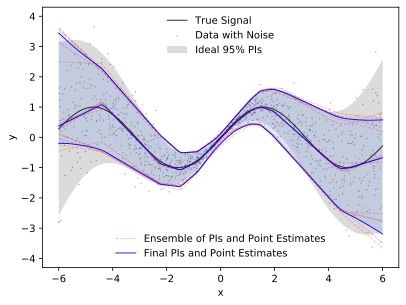

In [13]:
plot_predictions(**dataset.data, 
                 y_pred_ensemble=y_pred_ensemble, 
                 y_pred=y_pred, 
                 filename='toy_example_2')